In [ ]:
# unzip files:

! unzip -q img_test.zip
! unzip -q img_train.zip

In [5]:
import os

import pandas as pd
from tqdm.notebook import tqdm
from PIL import Image
import pandas as pd
import os
import numpy as np

xy_train_df = pd.read_csv('train_xy.csv')
x_test_df = pd.read_csv('test_x.csv')

In [6]:
# preprocess image data

def load_image(file):
    try:
        image = Image.open(
            file
        ).convert('LA').resize((64, 64))
        arr = np.array(image)
    except:
        arr = np.zeros((64, 64, 2))
    return arr


# loading images:
x_image = np.array([load_image(i) for i in tqdm(xy_train_df.image)])

# loading summary: (force convert some of the non-string cell to string)
x_text = xy_train_df.summary.astype('str')


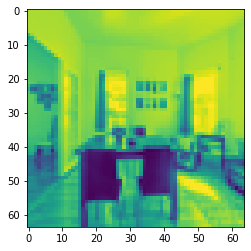

In [7]:
# check image loading
import matplotlib.pyplot as plt
plt.imshow(x_image[0, :, :, 0])

In [ ]:
from sklearn.model_selection import train_test_split

# labels:
y_price = xy_train_df.price
y_type = xy_train_df.type.astype('category').cat.codes

len_price = len(y_price.unique())
len_type = len(y_type.unique())
print('unique values for price category', len_price, y_price.unique())
print('unique values for type category', len_type, y_type.unique())

# splitting:

x_tr_image, x_vl_image, x_tr_text, x_vl_text, y_tr_price, y_vl_price, y_tr_type, y_vl_type = train_test_split(
    x_image, 
    x_text,
    y_price,
    y_type,
    test_size=0.2)

print(np.shape(x_tr_image))
print(np.shape(x_vl_image))
print(np.shape(y_tr_price))
print(np.shape(y_vl_price))
print(np.shape(y_tr_type))
print(np.shape(y_vl_type))

unique values for price category 3 [1 0 2]
unique values for type category 24 [ 1 17 22 10 18 20  5  2  8  4 23 13 15 16 14 11 19  0 21  3  6 12  7  9]
(6101, 64, 64, 2)
(1526, 64, 64, 2)
(6101,)
(1526,)
(6101,)
(1526,)


In [ ]:
# preprocess text data

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pprint import pprint

vocab_size = 40000
max_len = 100


# build vocabulary from training set
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(x_tr_text)


def _preprocess(list_of_text):
    return pad_sequences(
        tokenizer.texts_to_sequences(list_of_text),
        maxlen=max_len,
        padding='post',
    )
    

# padding is done inside: 
x_tr_text_id = _preprocess(x_tr_text)
x_vl_text_id = _preprocess(x_vl_text)

print(x_tr_text_id.shape)
print(x_vl_text_id.shape)

(6101, 100)
(1526, 100)


In [ ]:
pprint(tokenizer.sequences_to_texts(x_tr_text_id[:5]))

['your private sanctuary victorian style beautiful charming home only 20 '
 'minutes from downtown montreal 5 minutes from the trudeau airport central '
 'location quiet neighbourhood close to restaurants grocery stores bus stop up '
 'the road with lots of private land and plenty of storage very spacious '
 "private driveway large enough to fit 8 vehicles don't have to worry about "
 'parking stones throw away from waterfront across the street from park tennis '
 'basketball hockey',
 "mon logement est proche de le parc lafontaine l'avenue mont royal métro mon "
 'épicier piste cyclable centre ville petits cafés autobus et metro vous '
 "apprécierez mon logement pour l'emplacement le quartier les espaces "
 "extérieurs l'ambiance et les gens mon logement est parfait pour les couples "
 'et les familles avec enfants',
 'nestled in the heart of the plateau at villeneuve and st laurent enjoy a '
 'large queen mattress with your nearby bathroom and shower above you have '
 "access to an i

In [ ]:
print('total words in the dictionary:', tokenizer.num_words)

total words in the dictionary: 40000


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import collections
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D
from tensorflow.keras.optimizers import Adam

in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 2))

# text part
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text)
averaged = tf.reduce_mean(embedded, axis=1)


# image part
cov = Conv2D(32, (16, 16))(in_image)
pl = MaxPool2D((16, 16))(cov)
flattened = Flatten()(pl)


# fusion:
fused = tf.concat([averaged, flattened], axis=-1)

# multi-objectives (each is a multi-class classification)
p_price = Dense(len_price, activation='softmax', name='price')(fused)
p_type = Dense(len_type, activation='softmax', name='type')(fused)


model = keras.Model(
    inputs={
        'summary': in_text,
        'image': in_image
    },
    outputs={
        'price': p_price,
        'type': p_type,
    },
)


model.compile(
    optimizer=Adam(),
    loss={
        'price': 'sparse_categorical_crossentropy',
        'type': 'sparse_categorical_crossentropy',
    },
    loss_weights={
        'price': 0.5,
        'type': 0.5,       
    },
    metrics={
        'price': ['SparseCategoricalAccuracy'],
        'type': ['SparseCategoricalAccuracy'],
    },
)


model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 2)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 49, 49, 32)   16416       input_4[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 100)     4000000     input_3[0][0]                    
_______________________________________________________________________________________

In [ ]:
history = model.fit(
    x={
        'summary': x_tr_text_id,
        'image': x_tr_image
    },
    y={
        'price': y_tr_price,
        'type': y_tr_type,
    },
    epochs=20,
    batch_size=16,
    validation_data=(
        {
            'summary': x_vl_text_id,
            'image': x_vl_image
         }, 
        {
            'price': y_vl_price,
            'type': y_vl_type,
        }),
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=5, )
    ],
    verbose=1
)

Epoch 1/20
305/305 [==============================] - 12s 39ms/step - loss: 5.6183 - price_loss: 1.7225 - type_loss: 3.8958 - price_sparse_categorical_accuracy: 0.7863 - type_sparse_categorical_accuracy: 0.7693 - val_loss: 16.4726 - val_price_loss: 6.2020 - val_type_loss: 10.2706 - val_price_sparse_categorical_accuracy: 0.6937 - val_type_sparse_categorical_accuracy: 0.7527
Epoch 2/20
305/305 [==============================] - 12s 39ms/step - loss: 5.1698 - price_loss: 1.5501 - type_loss: 3.6197 - price_sparse_categorical_accuracy: 0.8008 - type_sparse_categorical_accuracy: 0.7738 - val_loss: 12.6485 - val_price_loss: 4.1276 - val_type_loss: 8.5209 - val_price_sparse_categorical_accuracy: 0.6667 - val_type_sparse_categorical_accuracy: 0.6544
Epoch 3/20
305/305 [==============================] - 12s 40ms/step - loss: 25.8703 - price_loss: 7.3216 - type_loss: 18.5487 - price_sparse_categorical_accuracy: 0.6912 - type_sparse_categorical_accuracy: 0.6965 - val_loss: 81.9663 - val_price_loss

In [ ]:
x_test_summary = _preprocess(x_test_df.summary.astype(str))
x_test_image = np.array([load_image(i) for i in tqdm(x_test_df.image)])


In [ ]:
y_predict = model.predict(
    {
        'summary': x_test_summary,
        'image': x_test_image
    }
)

price_predicted = y_predict['price']
print(price_predicted)
price_category_predicted = np.argmax(price_predicted, axis=1)
print(price_category_predicted)

pd.DataFrame(
    {'id': x_test_df.id,
     'price': price_category_predicted}).to_csv('sample_submission.csv', index=False)

[[9.9591368e-01 1.7761519e-09 4.0862821e-03]
 [1.0000000e+00 1.3375651e-09 4.6718315e-12]
 [9.9983203e-01 2.2399130e-10 1.6794473e-04]
 ...
 [2.9095626e-02 9.7090435e-01 3.2091119e-09]
 [1.0000000e+00 1.2734681e-17 6.6337732e-30]
 [9.9572611e-01 4.2736656e-03 1.9571750e-07]]
[0 0 0 ... 1 0 0]
